# Image Segmentation U-Net

+ [https://ithelp.ithome.com.tw/articles/10240314](https://ithelp.ithome.com.tw/articles/10240314)
+ [https://www.kaggle.com/tikutiku/hubmap-tilespadded-inference-v2](https://www.kaggle.com/tikutiku/hubmap-tilespadded-inference-v2)

以 SKNet50 使用 kernel size = 3, 5 為 Encoder

# Load data

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!tar -xf "/content/drive/MyDrive/Colab Notebooks/annotations.tar.gz" -C /content
!tar -xf "/content/drive/MyDrive/Colab Notebooks/images.tar.gz" -C /content

In [30]:
import os

# https://stackoverflow.com/questions/60058588/tesnorflow-2-0-tf-random-set-seed-not-working-since-i-am-getting-different-resul
SEED = 2021
os.environ['PYTHONHASHSEED'] = str(SEED)

In [31]:
import numpy
import math
import random

VERSION = 'SKNet50-UNet'
DATA_ROOT_DIR = '/content/'
SEED = 2021
IMG_SIZE = (160, 160)
NUM_CLASSES = 4
BATCH_SIZE = 25
EPOCHES = 50

import tensorflow.keras as keras
from keras import layers, models
import tensorflow as tf

def reset_random_seed():
    os.environ['PYTHONHASHSEED'] = str(SEED)
    numpy.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)
reset_random_seed()

In [32]:
files = []

for file in os.listdir(DATA_ROOT_DIR + 'images'):
    # file = Abyssinian_1.jpg
    if file.endswith('jpg'):
        fn = file.split('.')[0]
        if os.path.isfile(DATA_ROOT_DIR + 'annotations/trimaps/' + fn + '.png'):
            files.append(fn)
files = sorted(files)

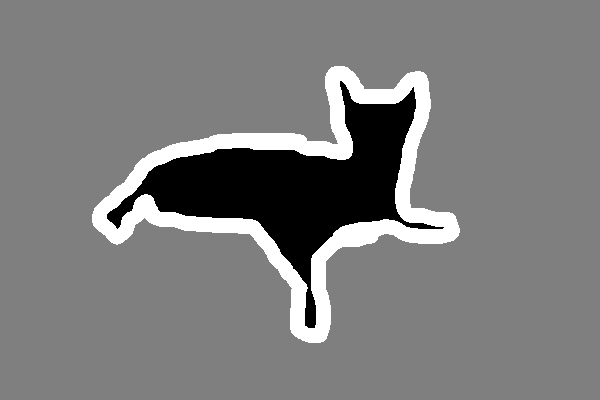

In [33]:
from IPython.display import display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
import PIL

# ImageOps.autocontrast() method maximizes (normalize) image contrast. 
# This function calculates a histogram of the input image, 
# removes cutoff percent of the lightest and darkest pixels from the histogram, 
# and remaps the image so that the darkest pixel becomes black (0), 
# and the lightest becomes white (255).

img = PIL.ImageOps.autocontrast(load_img(DATA_ROOT_DIR + 'annotations/trimaps/' + files[0] + '.png'))
display(img)

## Data Generator

In [34]:
# reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class OxfordPets(keras.utils.Sequence):
    def __init__(self, files):
        self.files = files
    def __len__(self):
        return math.ceil(len(self.files) / BATCH_SIZE)
    def __getitem__(self, index):
        x, y = [], []
        for i in range(index * BATCH_SIZE, min((index+1) * BATCH_SIZE, len(self.files))):
            # target size in load_img
            # (img_height, img_width)
            x.append(numpy.array(load_img(DATA_ROOT_DIR + 'images/' + self.files[i] + '.jpg', target_size = IMG_SIZE), dtype='float32'))
            y.append(numpy.array(load_img(DATA_ROOT_DIR + 'annotations/trimaps/' + self.files[i] + '.png', target_size = IMG_SIZE, color_mode="grayscale"), dtype='uint8'))

        return numpy.array(x), numpy.array(y)


## Build model

In [35]:
class SKUnit(keras.Model):
    def __init__(self, filters, strides, M=2, G=32, r=16, L=32):
        """ Constructor
        Args:
            M: the number of branchs.
            G: num of convolution groups.
            r: the ratio for compute d, the length of z.
            L: the minimum dim of the vector z in paper, default 32.
        """
        super().__init__()
        self.M = M
        self.filters = filters

        self.convs = []  # 各分支的卷積層
        for i in range(M):
            self.convs.append(models.Sequential([
                layers.Conv2D(filters, 3+2*i, strides,
                              padding='same', groups=G),
                layers.BatchNormalization(),
                layers.Activation('relu'),
            ]))

        self.gap = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(max(filters//r, L))
        self.fcs = []
        for i in range(M):
          self.fcs.append(layers.Dense(filters))

    def call(self, input):
        # 計算不同分支的 U
        for i in range(self.M):
            feat = self.convs[i](input)
            feat = tf.expand_dims(feat, axis=-1)
            feats_U = feat if i == 0 else tf.concat([feats_U, feat], axis=-1)

        # feats_U (H, W, filters, M)

        # 對 U 做全局平均池化得到 s
        feats_s = self.gap(tf.reduce_sum(feats_U, axis=-1))

        # s 經過全連結層可以得到 z
        feats_Z = self.fc(feats_s)

        for i in range(self.M):
            fcs = self.fcs[i](feats_Z)
            att_vec = fcs if i == 0 else tf.concat([att_vec, fcs], axis=-1)

        att_vec = layers.Reshape((1, 1, self.filters, self.M))(att_vec)
        att_vec = tf.nn.softmax(att_vec, axis=-1)

        # att_vec (1, 1, filters, M)

        mul = tf.multiply(feats_U, att_vec)

        return tf.reduce_sum(mul, axis=-1)


class SKConv(keras.Model):
    def __init__(self, filters, strides, M=2, G=32, r=16, L=32):
        super().__init__()
        self.filters = filters
        self.strides = strides

        #----------------------------- conv1x1_1 -----------------------------
        self.conv1x1_1 = layers.Conv2D(filters, 1, 1)
        self.bn1 = layers.BatchNormalization()

        #------------------------------ middle -------------------------------
        self.skunit = SKUnit(filters, strides, M, G, r, L)
        self.bn2 = layers.BatchNormalization()

        #----------------------------- conv1x1_2 -----------------------------
        self.conv1x1_2 = layers.Conv2D(filters*2, 1, 1)
        self.bn3 = layers.BatchNormalization()

    def build(self, input_shape):
        if input_shape[-1] != self.filters*2:
            self.shortcut = models.Sequential([
                layers.Conv2D(self.filters*2, 1, self.strides),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = models.Sequential()

    def call(self, input):
        x = input
        x = self.conv1x1_1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.skunit(x)
        x = self.bn2(x)

        x = self.conv1x1_2(x)
        x = self.bn3(x)
        x = tf.nn.relu(x)

        shortcut = self.shortcut(input)

        return tf.nn.relu(tf.add(x, shortcut))

class Encoder(keras.Model):
    def __init__(self, filters, strides, repeat, M=2, G=32, r=16, L=32):
        super().__init__()
        self.resBlocks = keras.Sequential()
        self.resBlocks.add(SKConv(filters, strides, M, G, r, L))
        for _ in range(1, repeat):
            self.resBlocks.add(
                SKConv(filters, 1, M, G, r, L))

    def call(self, inputs):
        return self.resBlocks(inputs)

    def get_config(self):
        return {}


class ChannelAttention(keras.Model):
    def __init__(self, reduction):
        super().__init__()
        self.globalMaxPool = layers.GlobalMaxPooling2D(keepdims=True)
        self.globalAvgPool = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = reduction

    def build(self, input_shape):
        self.fc = keras.Sequential([
            layers.Conv2D(input_shape[-1]//self.reduction, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(input_shape[-1], 1, padding='valid')
        ])

    def call(self, inputs):
        x1 = self.globalMaxPool(inputs)
        x2 = self.globalAvgPool(inputs)
        x1 = self.fc(x1)
        x2 = self.fc(x2)
        x = tf.nn.sigmoid(layers.add([x1, x2]))
        return x


class SpatialAttention(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv3x3 = layers.Conv2D(1, 3, padding='same')

    def call(self, inputs):
        # https://github.com/kobiso/CBAM-tensorflow/blob/master/attention_module.py#L95
        x1 = tf.math.reduce_max(inputs, axis=3, keepdims=True)
        x2 = tf.math.reduce_mean(inputs, axis=3, keepdims=True)
        x = tf.concat([x1, x2], 3)
        x = self.conv3x3(x)
        x = tf.nn.sigmoid(x)
        return x


class CBAM(keras.Model):
    def __init__(self, reduction):
        super().__init__()
        self.channelAttention = ChannelAttention(reduction)
        self.spaialAttention = SpatialAttention()

    def call(self, inputs):
        x = inputs * self.channelAttention(inputs)
        x = x * self.spaialAttention(x)
        return x


class Decoder(keras.Model):
    def __init__(self, channels, upsample=True):
        super().__init__()
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

        if upsample:
            self.upsample = keras.Sequential([
                layers.UpSampling2D(2, interpolation='nearest')
            ])
        else:
            self.upsample = keras.Sequential()

        self.conv3x3_2 = layers.Conv2D(
            channels, 3, padding='same', use_bias=False)
        self.conv1x1 = layers.Conv2D(channels, 1, use_bias=False)
        self.cbam = CBAM(reduction=16)

    def build(self, input_shape):
        self.conv3x3_1 = layers.Conv2D(
            input_shape[-1], 3, padding='same', use_bias=False)

    def call(self, inputs):
        x = self.bn1(inputs)
        x = tf.nn.relu(x)
        x = self.upsample(x)
        x = self.conv3x3_1(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        x = self.conv3x3_2(x)
        x = self.cbam(x)

        shortcut = self.conv1x1(self.upsample(inputs))
        x += shortcut
        return x

    def get_config(self):
        return {}


def SKNet50UNet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Encode by SKNet50
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x0 = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # SKNet50
    x1 = Encoder(filters=128, strides=1, repeat=3)(x0)
    x2 = Encoder(filters=256, strides=2, repeat=4)(x1)
    x3 = Encoder(filters=512, strides=2, repeat=6)(x2)
    x4 = Encoder(filters=1024, strides=2, repeat=5)(x3)

    # Center Block
    y5 = layers.Conv2D(512, 3, padding='same', use_bias=False)(x4)

    # Decode
    y4 = Decoder(64)(layers.Concatenate(axis=3)([x4, y5]))
    y3 = Decoder(64)(layers.Concatenate(axis=3)([x3, y4]))
    y2 = Decoder(64)(layers.Concatenate(axis=3)([x2, y3]))
    y1 = Decoder(64)(layers.Concatenate(axis=3)([x1, y2]))
    y0 = Decoder(64)(y1)

    # Hypercolumn
    y4 = layers.UpSampling2D(16, interpolation='bilinear')(y4)
    y3 = layers.UpSampling2D(8, interpolation='bilinear')(y3)
    y2 = layers.UpSampling2D(4, interpolation='bilinear')(y2)
    y1 = layers.UpSampling2D(2, interpolation='bilinear')(y1)
    hypercolumn = layers.Concatenate(axis=3)([y0, y1, y2, y3, y4])

    # Final conv
    outputs = keras.Sequential([
        layers.Conv2D(64, 3, padding='same', use_bias=False),
        layers.ELU(),
        layers.Conv2D(num_classes, 1, use_bias=False)
    ])(hypercolumn)

    outputs = tf.nn.softmax(outputs)
    return keras.Model(inputs, outputs)

## Start Training!

In [36]:
keras.backend.clear_session()
reset_random_seed()

m = SKNet50UNet(IMG_SIZE+(3,), NUM_CLASSES)
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 80, 80, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

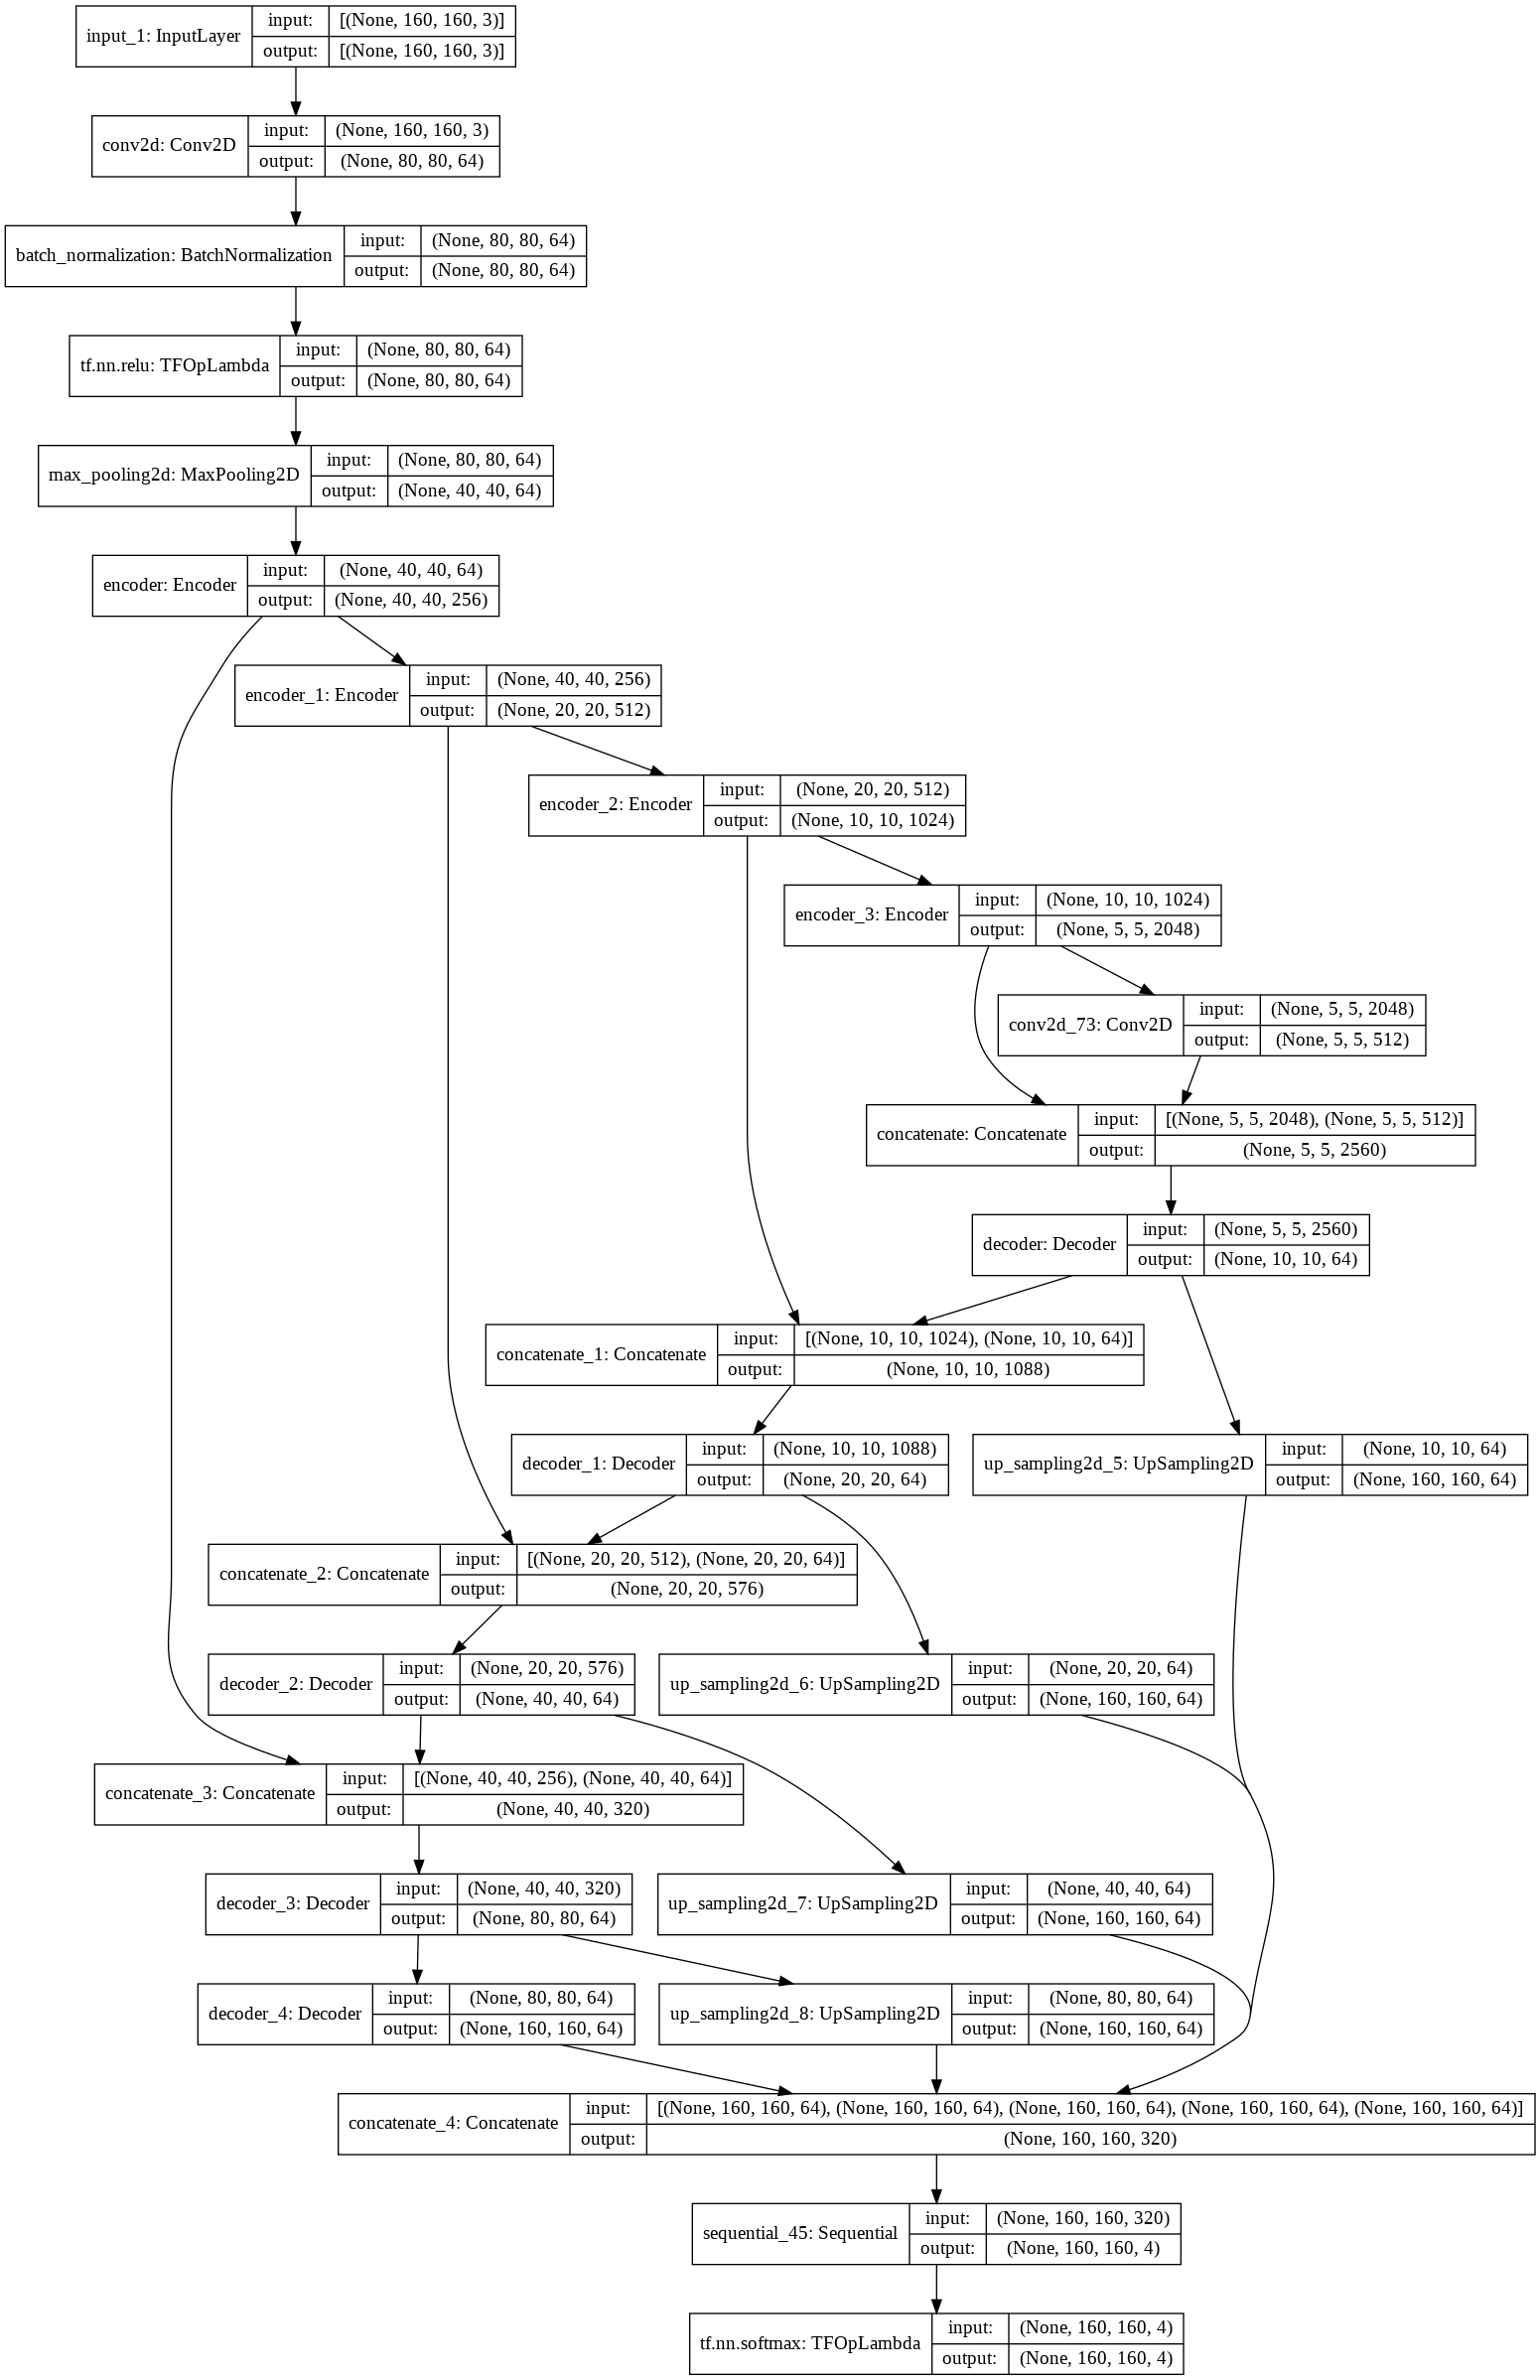

In [37]:
keras.utils.plot_model(m, show_shapes=True)

In [38]:
files = sorted(files)
rng = numpy.random.default_rng(SEED)
rng.shuffle(files)

middle = math.ceil(len(files) * 0.8)
train = OxfordPets(files[:middle])
test = OxfordPets(files[middle:])

# 確定每次訓練時 files 的順序皆相同
print(files[:10])

['japanese_chin_19', 'english_setter_184', 'Bengal_103', 'Bengal_12', 'american_bulldog_133', 'shiba_inu_12', 'Bombay_69', 'leonberger_189', 'Bombay_171', 'saint_bernard_103']


In [39]:
keras.backend.clear_session()
reset_random_seed()

callbacks = [
    keras.callbacks.ModelCheckpoint(DATA_ROOT_DIR + VERSION + ".h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
]

m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = m.fit(train, validation_data=test, epochs=EPOCHES, callbacks=callbacks)

Epoch 1/50
237/237 [==============================] - 408s 2s/step - loss: 2.3814 - accuracy: 0.6922 - val_loss: 0.9067 - val_accuracy: 0.5875
Epoch 2/50
237/237 [==============================] - 389s 2s/step - loss: 0.5807 - accuracy: 0.7761 - val_loss: 0.6905 - val_accuracy: 0.7037
Epoch 3/50
237/237 [==============================] - 390s 2s/step - loss: 0.4922 - accuracy: 0.8097 - val_loss: 0.7105 - val_accuracy: 0.7492
Epoch 4/50
237/237 [==============================] - 390s 2s/step - loss: 0.4326 - accuracy: 0.8316 - val_loss: 0.4640 - val_accuracy: 0.8206
Epoch 5/50
237/237 [==============================] - 389s 2s/step - loss: 0.3840 - accuracy: 0.8514 - val_loss: 0.5305 - val_accuracy: 0.8330
Epoch 6/50
237/237 [==============================] - 390s 2s/step - loss: 0.3536 - accuracy: 0.8625 - val_loss: 0.6388 - val_accuracy: 0.8155
Epoch 7/50
237/237 [==============================] - 390s 2s/step - loss: 0.3291 - accuracy: 0.8721 - val_loss: 0.9314 - val_accuracy: 0.7760

# Evaluate

0.3313490152359009


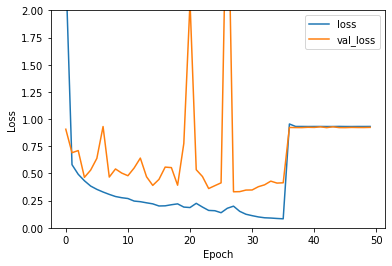

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

print(min(history.history['val_loss']))

0.9024556279182434


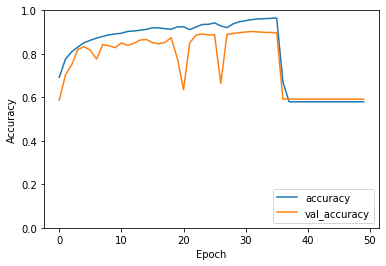

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

print(max(history.history['val_accuracy']))

In [42]:
import json
with open(DATA_ROOT_DIR + VERSION + '.json', 'w') as f:
    data = {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }
    json.dump(data, f)

## Show result

In [43]:
def mask_to_img(predict):
    mask = numpy.argmax(predict, axis=-1)
    # numpy.expand_dims() expand the shape of an array.
    # Insert a new axis that will appear at the axis position in the expanded
    # array shape.
    mask = numpy.expand_dims(mask, axis = -1)
    return PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

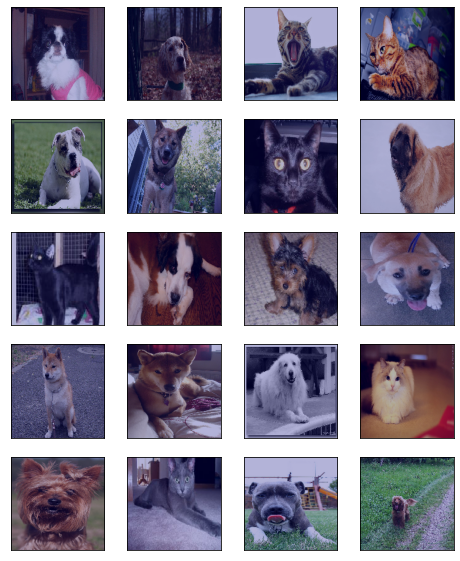

In [44]:
demo_data = OxfordPets(files[:20])
demo_res = m.predict(demo_data)

plt.figure(figsize=(8, 10))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(keras.preprocessing.image.array_to_img(demo_data.__getitem__(0)[0][i]))
    plt.imshow(mask_to_img(demo_res[i]), cmap='jet', alpha=0.3)

plt.show()
plt.close()

In [45]:
import shutil
val_loss = min(history.history['val_loss'])

shutil.copy(DATA_ROOT_DIR + VERSION + '.json', '/content/drive/MyDrive/Models/%s-%.4f.json' % (VERSION, val_loss))
shutil.copy(DATA_ROOT_DIR + VERSION + '.h5', '/content/drive/MyDrive/Models/%s-%.4f.h5' % (VERSION, val_loss))

'/content/drive/MyDrive/Models/SKNet50-UNet-0.3313.h5'